In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
import keras.backend as K

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from aparent.data.aparent_data_plasmid_legacy import load_data

from analyze_aparent_conv_layers_helpers import *


Using TensorFlow backend.


In [2]:
#Load random MPRA data

file_path = '../data/random_mpra_legacy/combined_library/processed_data_lifted/'
plasmid_gens = load_data(batch_size=32, valid_set_size=1000, test_set_size=40000, kept_libraries=[22], canonical_pas=True, no_dse_canonical_pas=True, file_path=file_path)


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Training set size = 142589
Validation set size = 1000
Test set size = 40000


In [3]:
#Load legacy APARENT model (lifted from theano)

model_name = 'aparent_theano_legacy_30_31_34'#_pasaligned

save_dir = os.path.join(os.getcwd(), '../saved_models/legacy_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion
conv_layer_iso_model = Model(
    inputs = aparent_model.inputs,
    outputs = [
        aparent_model.get_layer('iso_conv_layer_1').output,
        aparent_model.get_layer('iso_out_layer_1').output
    ]
)

In [5]:
#Predict from test data generator
iso_conv_1_out, iso_pred = conv_layer_iso_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)

iso_conv_1_out = np.reshape(iso_conv_1_out, (iso_conv_1_out.shape[0], iso_conv_1_out.shape[1], iso_conv_1_out.shape[2]))

iso_pred = np.ravel(iso_pred[:, 1])
logodds_pred = np.log(iso_pred / (1. - iso_pred))

#Retrieve one-hot input sequences
onehot_seqs = np.concatenate([plasmid_gens['test'][i][0][0][:, 0, :, :] for i in range(len(plasmid_gens['test']))], axis=0)


In [6]:
#Mask for simple library (Alien1)
mask_seq = ('X' * 4) + ('N' * (45 + 6 + 45 + 6 + 45)) + ('X' * 27)

for j in range(len(mask_seq)) :
    if mask_seq[j] == 'X' :
        iso_conv_1_out[:, :, j] = 0


In [7]:
#Layer 1: Compute Max Activation Correlation maps and PWMs
filter_width = 8
n_samples = 5000

pwms = np.zeros((iso_conv_1_out.shape[1], filter_width, 4))
pwms_top = np.zeros((iso_conv_1_out.shape[1], filter_width, 4))

for k in range(iso_conv_1_out.shape[1]) :
    
    for i in range(iso_conv_1_out.shape[0]) :
        max_j = np.argmax(iso_conv_1_out[i, k, :])
        if iso_conv_1_out[i, k, max_j] > 0 :
            pwms[k, :, :] += onehot_seqs[i, max_j: max_j+filter_width, :]
    
    sort_index = np.argsort(np.max(iso_conv_1_out[:, k, :], axis=-1))[::-1]
    for i in range(n_samples) :
        max_j = np.argmax(iso_conv_1_out[sort_index[i], k, :])
        if iso_conv_1_out[sort_index[i], k, max_j] > 0 :
            pwms_top[k, :, :] += onehot_seqs[sort_index[i], max_j: max_j+filter_width, :]
    
    
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

r_vals = np.zeros((iso_conv_1_out.shape[1], iso_conv_1_out.shape[2]))

for k in range(iso_conv_1_out.shape[1]) :
    for j in range(iso_conv_1_out.shape[2]) :
        if np.any(iso_conv_1_out[:, k, j] > 0.) :
            r_val, _ = pearsonr(iso_conv_1_out[:, k, j], logodds_pred)
            r_vals[k, j] = r_val if not np.isnan(r_val) else 0


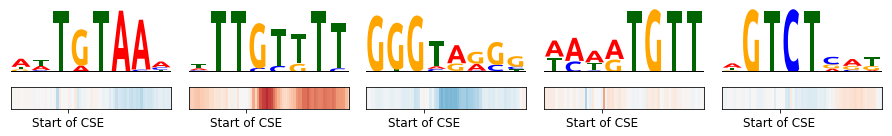

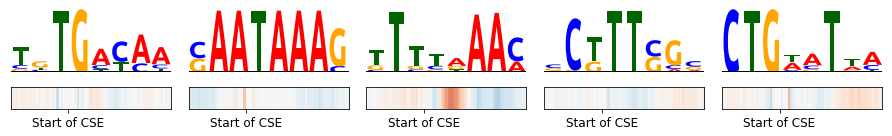

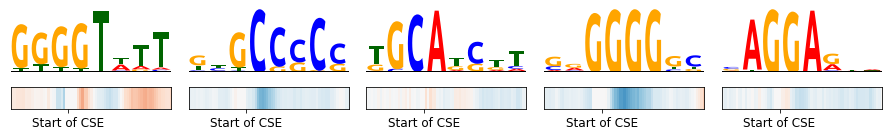

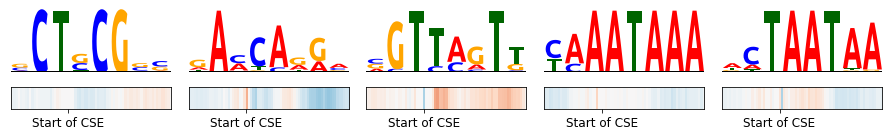

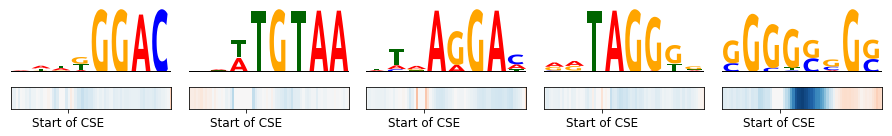

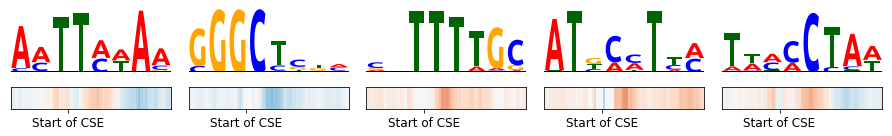

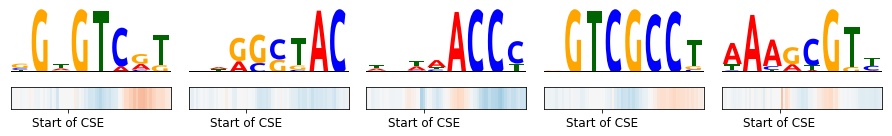

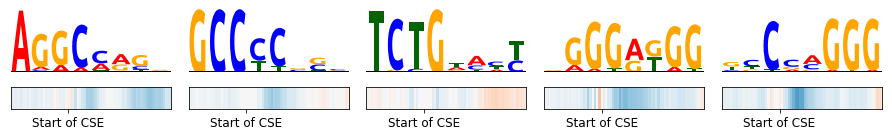

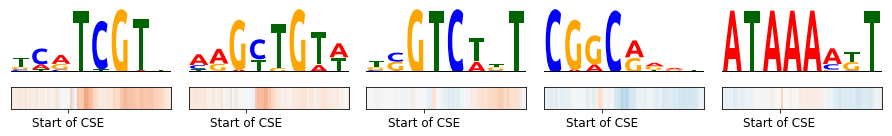

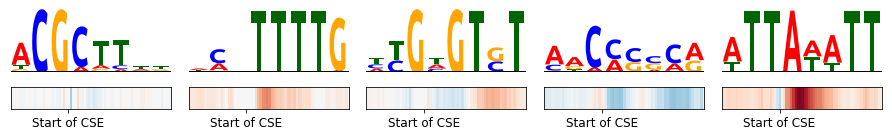

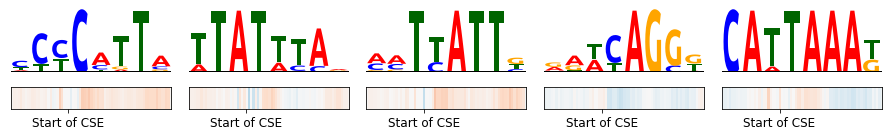

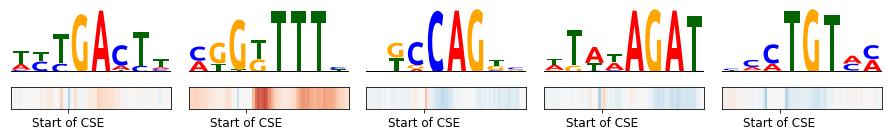

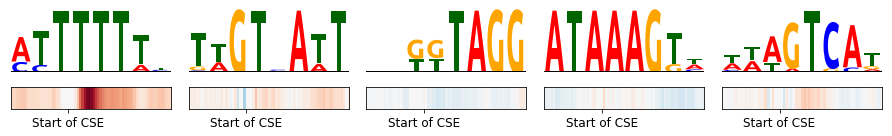

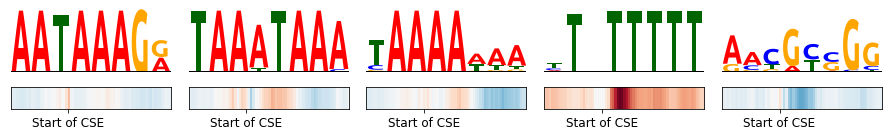

In [9]:
#Plot Max Activation PWMs and Correlation maps

n_filters_per_row = 5

n_rows = int(pwms.shape[0] / n_filters_per_row)
k = 0
for row_i in range(n_rows) :
    
    f, ax = plt.subplots(2, n_filters_per_row, figsize=(2.5 * n_filters_per_row, 2), gridspec_kw = {'height_ratios':[3, 1]})

    for kk in range(n_filters_per_row) :
        plot_pwm_iso_logo(pwms_top, r_vals, k, ax[0, kk], ax[1, kk], seq_start=24, seq_end=95, cse_start=49)
        k += 1

    plt.tight_layout()
    plt.show()



In [10]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion
conv_layer_iso_model = Model(
    inputs = aparent_model.inputs,
    outputs = [
        aparent_model.get_layer('iso_conv_layer_2').output,
        aparent_model.get_layer('iso_out_layer_1').output
    ]
)

In [11]:
#Predict from test data generator
iso_conv_2_out, iso_pred = conv_layer_iso_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)

iso_conv_2_out = np.reshape(iso_conv_2_out, (iso_conv_2_out.shape[0], iso_conv_2_out.shape[1], iso_conv_2_out.shape[2]))

iso_pred = np.ravel(iso_pred[:, 1])
logodds_pred = np.log(iso_pred / (1. - iso_pred))

#Retrieve one-hot input sequences
onehot_seqs = np.concatenate([plasmid_gens['test'][i][0][0][:, 0, :, :] for i in range(len(plasmid_gens['test']))], axis=0)


In [12]:
#Layer 2: Compute Max Activation Correlation maps and PWMs
filter_width = 19
n_samples = 200

pwms = np.zeros((iso_conv_2_out.shape[1], filter_width, 4))
pwms_top = np.zeros((iso_conv_2_out.shape[1], filter_width, 4))

for k in range(iso_conv_2_out.shape[1]) :
    
    for i in range(iso_conv_2_out.shape[0]) :
        max_j = np.argmax(iso_conv_2_out[i, k, :])
        if iso_conv_2_out[i, k, max_j] > 0 :
            pwms[k, :, :] += onehot_seqs[i, max_j * 2: max_j * 2 + filter_width, :]
    
    sort_index = np.argsort(np.max(iso_conv_2_out[:, k, :], axis=-1))[::-1]
    for i in range(n_samples) :
        max_j = np.argmax(iso_conv_2_out[sort_index[i], k, :])
        if iso_conv_2_out[sort_index[i], k, max_j] > 0 :
            pwms_top[k, :, :] += onehot_seqs[sort_index[i], max_j * 2: max_j * 2 + filter_width, :]
    
    
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

r_vals = np.zeros((iso_conv_2_out.shape[1], iso_conv_2_out.shape[2]))

for k in range(iso_conv_2_out.shape[1]) :
    for j in range(iso_conv_2_out.shape[2]) :
        if np.any(iso_conv_2_out[:, k, j] > 0.) :
            r_val, _ = pearsonr(iso_conv_2_out[:, k, j], logodds_pred)
            r_vals[k, j] = r_val if not np.isnan(r_val) else 0


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


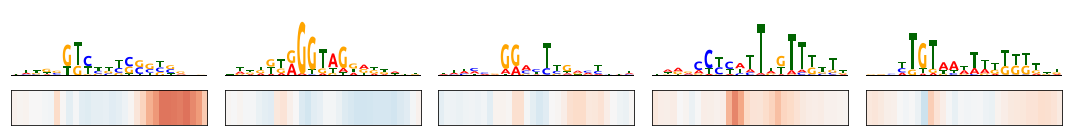

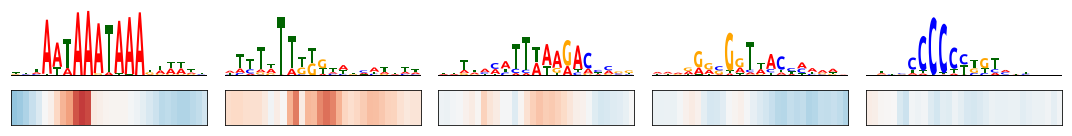

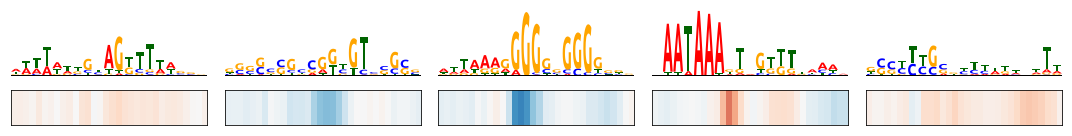

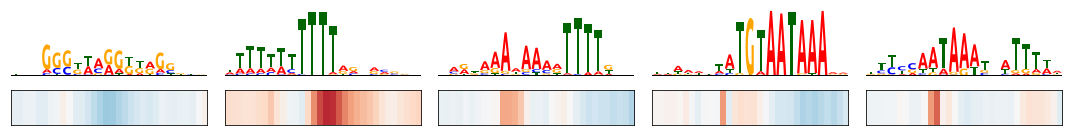

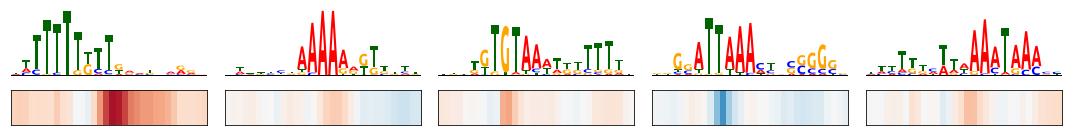

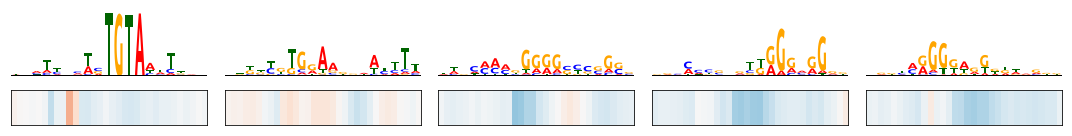

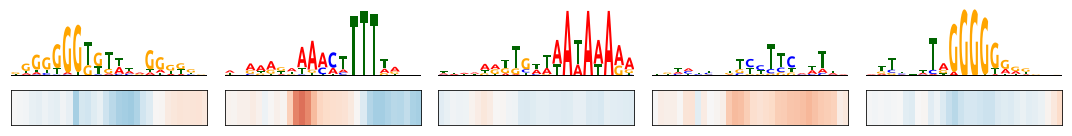

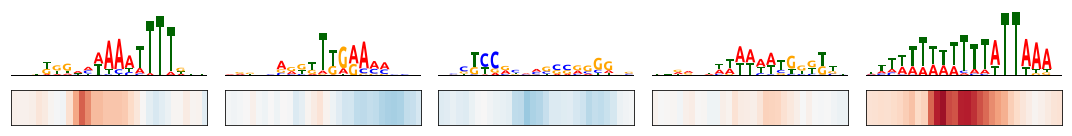

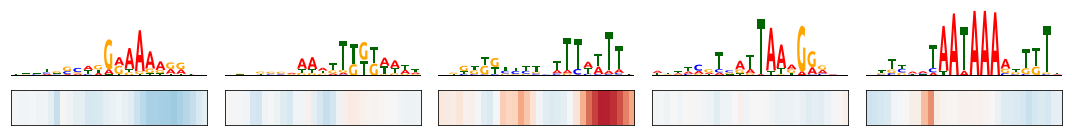

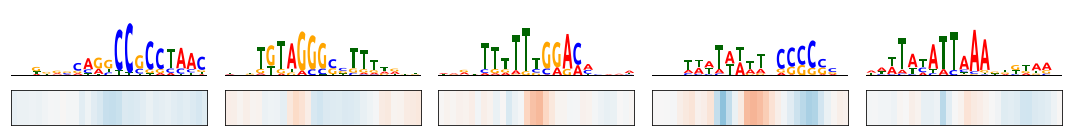

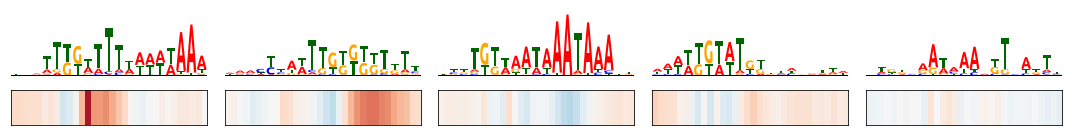

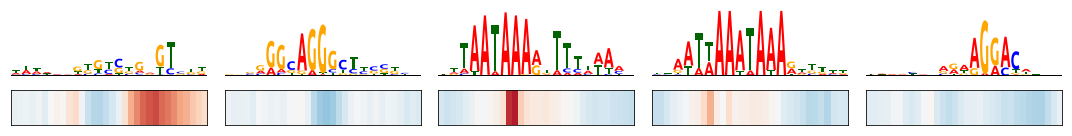

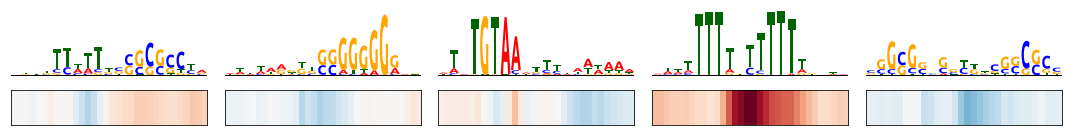

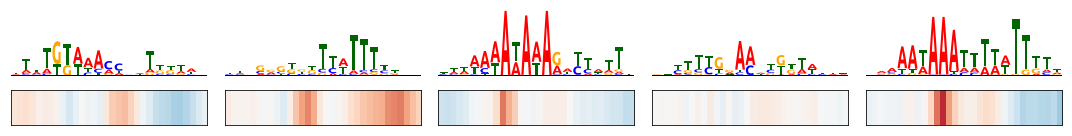

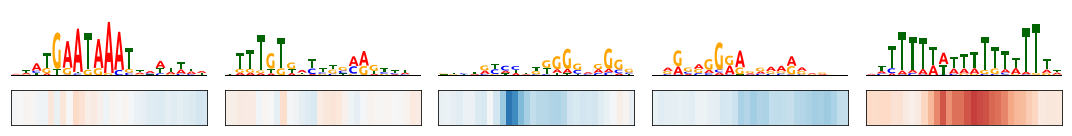

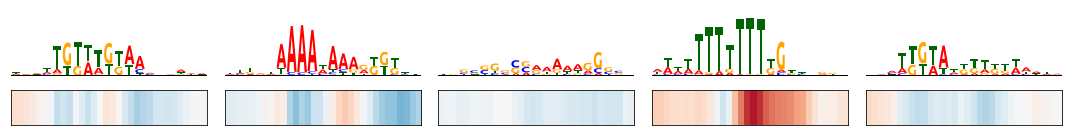

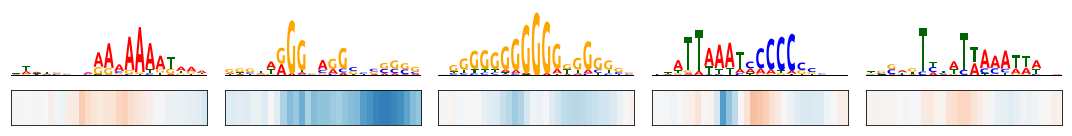

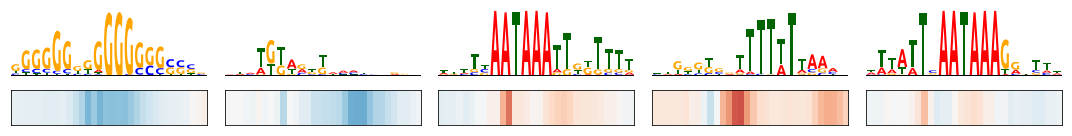

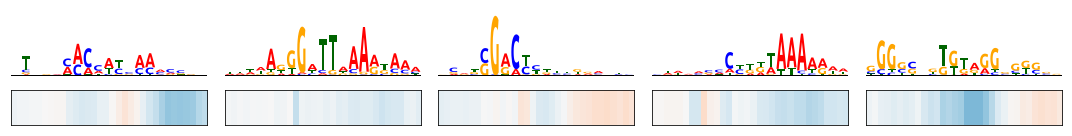

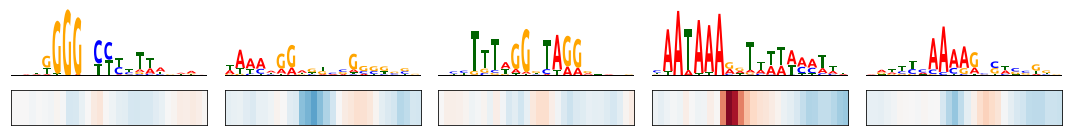

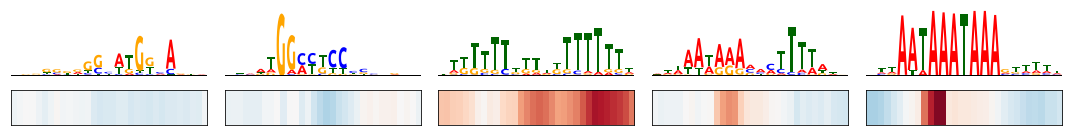

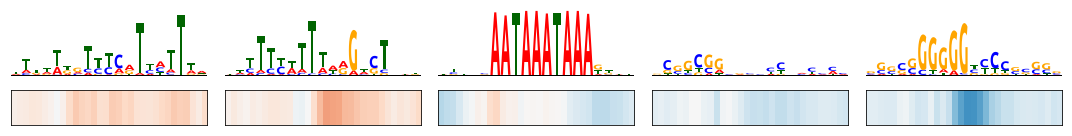

In [16]:
#Plot Max Activation PWMs and Correlation maps

n_filters_per_row = 5

n_rows = int(pwms.shape[0] / n_filters_per_row)
k = 0
for row_i in range(n_rows) :
    
    f, ax = plt.subplots(2, n_filters_per_row, figsize=(3 * n_filters_per_row, 2), gridspec_kw = {'height_ratios':[3, 1.5]})

    for kk in range(n_filters_per_row) :
        plot_pwm_iso_logo(pwms_top, r_vals, k, ax[0, kk], ax[1, kk], seq_start=12, seq_end=44)
        k += 1

    plt.tight_layout()
    plt.show()

